# Zero-normalized cross-correlation (ZNCC)

In signal processing, cross-correlation is a measure of similarity of two series as a function of the displacement of one relative to the other.

For digital image processing applications in which the brightness of the image and template can vary due to lighting and exposure conditions, the images can be first normalized. This is typically done at every step by subtracting the mean and dividing by the standard deviation. That is, the cross-correlation of a template  $g_2$ with a larger reference image $g_1$ is

$$\begin{aligned}
\rho_{12}(u, v) &= \frac{\sigma_{g_1 g_2}(u,v)}{\sigma_{g_1}(u, v) \sigma_{g_2}} \\
\sigma_{g_2}^2 &= \frac{1}{M-1} \sum_{m=1}^{M} \left( g_2(p_m, q_m) - \frac{1}{M} \sum_{m=1}^{M} g_2(p_m, q_m)\right)^2 \\
\sigma_{g_1}^2(u, v) &= \frac{1}{M-1} \sum_{m=1}^{M} \left( g_1(p_m + u, q_m + v) - \frac{1}{M} \sum_{m=1}^{M} g_1(p_m + u, q_m + v)\right)^2 \\
\sigma_{g_1 g_2}^2(u, v) &= \frac{1}{M-1} \sum_{m=1}^{M} \left[ \left( g_2(p_m, q_m) - \frac{1}{M} \sum_{m=1}^{M} g_2(p_m, q_m) \right) \cdot \left( g_1(p_m + u, q_m + v) - \frac{1}{M} \sum_{m=1}^{M} g_1(p_m + u, q_m + v) \right) \right]
\end{aligned}$$

where $M$ is the number of pixels in $g_2$, $\sigma_{g_2}$ is the standard deviation of intensity values of the template, $\sigma_{g_1}$ is the standard deviation of the reference image in the area overlayed by the template, and $\sigma_{g_1 g_2}$ is the covariance between intensity values of the template and the reference in the overlap area.

In [1]:
from typing import Union
import torch

def cross_correlation(
    reference: torch.Tensor,
    template: torch.Tensor,
    stride: Union[tuple, int] = 1,
    normalize: bool = True,
    center: bool = True,
) -> torch.Tensor:
    """Compute the zero-normalized cross-correlation between a reference and a template.

    The output tensor is the result of the batched sliding cross-correlation between
    a multi-channel reference matrix and a template matrix:
     - (normalize = False, center = False): Standard cross-correlation;
     - (normalize = True, center = False): Normalized cross-correlation (NCC);
     - (normalize = False, center = True): Zero cross-correlation (ZCC), generally performs as good as ZNCC, but is faster;
     - (normalize = True, center = True): Zero-normalized cross-correlation (ZNCC);

    Args:
        reference (torch.Tensor): Reference tensor, must be of shape (N, C_in, H_ref, W_ref).
        template (torch.Tensor): Template tensor, must be of shape (N, C_in, H_t, W_t).
        stride (Union[tuple, int]): Stride of the sliding window. Default to 1.
        normalize (bool): If True, the output is normalized by the Standard Deviation of the reference and template patches. Default to True.
        center (bool): If True, the output is normalized by the Mean of the reference and template patches. Default to True.
    
    Returns:
        torch.Tensor: Normalized cross correlation.
    
    Raises:
        ValueError: If the input dimensions are not correct.

    Example:
        >>> image = PIL.Image.open(requests.get("https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png", stream=True).raw)
        >>> reference = torchvision.transforms.ToTensor()(image).to(torch.float32)
        >>> template = reference[..., 240:280, 240:300]
        >>> matching = normalized_cross_correlation(reference.unsqueeze(dim=0), template.unsqueeze(dim=0))
        >>> plt.imshow(matching[0].numpy())
    
    References:
        https://en.wikipedia.org/w/index.php?title=Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)
    """

    # Check the input dimensions
    if not (reference.dim()==template.dim()==4):
        raise ValueError("Reference and template must have 4 dimensions.")
    
    if reference.shape[0] != template.shape[0]:
        raise ValueError("Reference and template must have the same batch size (N).")
    
    if reference.shape[1] != template.shape[1]:
        raise ValueError("Reference and template must have the same number of channel (C_in).")

    if (reference.shape[2] <= template.shape[2]) or (reference.shape[3] <= template.shape[3]):
        raise ValueError("Reference matrix must be larger than template matrix (H_ref>=H_t & W_ref>=W_t).")

    if isinstance(stride, int):
        stride_h=stride_w=stride
    elif isinstance(stride, tuple):
        if len(stride) != 2:
            raise ValueError("Stride must be a 2 dimensional tuple.")
        stride_h, stride_w = stride
    else:
        raise ValueError("Stride must be an integer or a 2 dimensional tuple.")
    
    # Get the template size
    template_h, template_w = template.shape[-2:]

    # 2D unfold of the batch of reference matrix
    # (N, C_in, H_ref, W_ref) -> (N, C_in, H_out, W_out, H_t, W_t)
    reference_patches = reference.unfold(
        dimension=-2,
        size=template_h,
        step=stride_h
    ).unfold(
        dimension=-2,
        size=template_w,
        step=stride_w
    )

    # Rearange dimensions to ease Standard Deviation and Mean computation
    # (N, C_in, H_out, W_out, H_t, W_t) -> (N, H_out, W_out, C_in, H_t, W_t)
    reference_patches = reference_patches.permute(0, 2, 3, 1, 4, 5)

    # Compute the Standard Deviation and Mean of the reference and template patches
    # (N, H_out, W_out, C_in, H_t, W_t) -> (N, H_out, W_out)
    if normalize:
        reference_std, reference_mean = torch.std_mean(reference_patches, dim=(-1, -2, -3), keepdim=False)
        # (N, C_in, H_out, W_out) -> (N)
        template_std, template_mean = torch.std_mean(template, dim=(-1, -2, -3), keepdim=False)
    elif center:
        reference_mean = torch.mean(reference_patches, dim=(-1, -2, -3), keepdim=False)
        template_mean = torch.mean(template, dim=(-1, -2, -3), keepdim=False)

    if normalize or center:
        # Add empty dimensions to the template and reference mean to ease subsequent operations
        # (N, H_out, W_out) -> (N, H_out, W_out, 1, 1, 1)
        reference_mean = reference_mean[..., None, None, None]
        # (N) -> (N, 1, 1, 1)
        template_mean = template_mean[..., None, None, None]

    # Compute the covariance between the reference and template patches
    # -> (N, H_out, W_out)
    if center:
        matching = ((reference_patches - reference_mean) * (template - template_mean)).sum(dim=(-1, -2, -3))
    else:
        matching = (reference_patches * template).sum(dim=(-1, -2, -3))

    if normalize:
        # Normalize by the Standard Deviation of the reference and template patches
        matching.div_(reference_std)
        matching.div_(template_std)

    return matching

500 ms ± 6.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
883 ms ± 8.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
977 ms ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.34 s ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


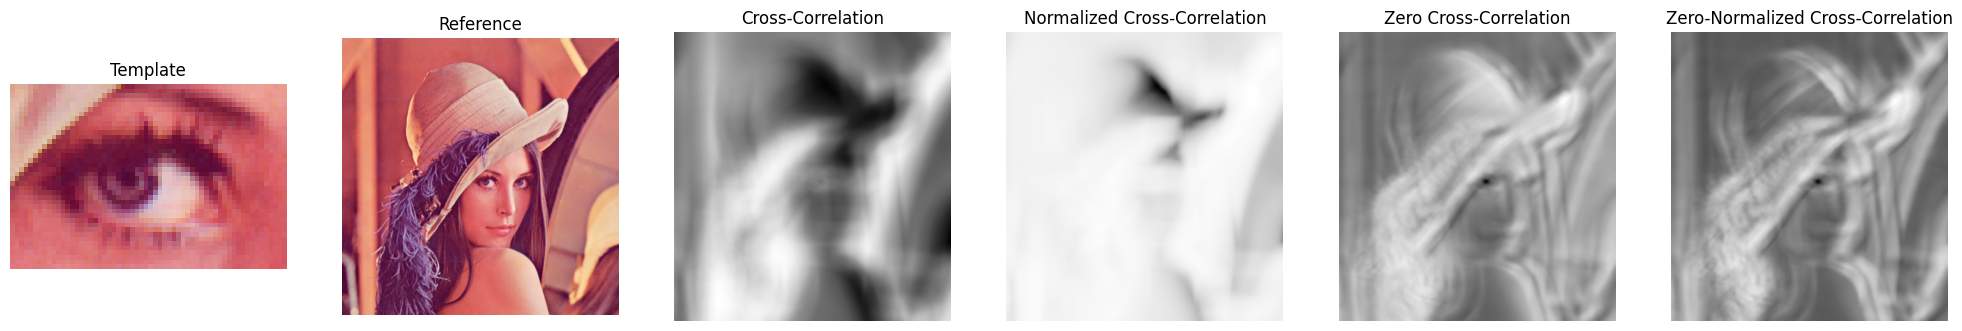

In [2]:
from PIL import Image
import requests
import torchvision
import matplotlib.pyplot as plt

image_url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"
image = Image.open(requests.get(image_url, stream=True).raw)
image = torchvision.transforms.functional.to_tensor(image).to(torch.float32)
image_window = image[..., 245:285, 240:300]

%timeit cross_correlation(image.unsqueeze(dim=0), image_window.unsqueeze(dim=0), normalize=False, center=False)
%timeit cross_correlation(image.unsqueeze(dim=0), image_window.unsqueeze(dim=0), normalize=True, center=False)
%timeit cross_correlation(image.unsqueeze(dim=0), image_window.unsqueeze(dim=0), normalize=False, center=True)
%timeit cross_correlation(image.unsqueeze(dim=0), image_window.unsqueeze(dim=0), normalize=True, center=True)

cc = cross_correlation(image.unsqueeze(dim=0), image_window.unsqueeze(dim=0), normalize=False, center=False)
ncc = cross_correlation(image.unsqueeze(dim=0), image_window.unsqueeze(dim=0), normalize=True, center=False)
zcc = cross_correlation(image.unsqueeze(dim=0), image_window.unsqueeze(dim=0), normalize=False, center=True)
zncc = cross_correlation(image.unsqueeze(dim=0), image_window.unsqueeze(dim=0), normalize=True, center=True)

fig, axs = plt.subplots(1, 6, figsize=(25, 8))
axs[0].set_title("Template")
axs[0].imshow(image_window.numpy().transpose(1, 2, 0))
axs[1].set_title("Reference")
axs[1].imshow(image.numpy().transpose(1, 2, 0))
axs[2].set_title("Cross-Correlation")
axs[2].imshow(cc[0].numpy(), cmap='Greys')
axs[3].set_title("Normalized Cross-Correlation")
axs[3].imshow(ncc[0].numpy(), cmap='Greys')
axs[4].set_title("Zero Cross-Correlation")
axs[4].imshow(zcc[0].numpy(), cmap='Greys')
axs[5].set_title(f"Zero-Normalized Cross-Correlation")
axs[5].imshow(zncc[0].numpy(), cmap='Greys')
for ax in axs:
    ax.set_axis_off()